# **Functions**

In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.metrics import top_k_categorical_accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import nltk
import re
import pickle
from collections import defaultdict


# Function to remove emojis and special characters from text
def remove_emojis_and_special_characters(text):
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)

    # Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Remove extra spaces
    text = re.sub(' +', ' ', text)

    return text



# Preprocessing pipeline
def preprocess_pipeline(data) -> 'list':
    # Split by newline character
    sentences = data.split('\n')
    for i in range(len(sentences)):
        sentences[i] = remove_emojis_and_special_characters(sentences[i])
    # Remove leading and trailing spaces
    sentences = [s.strip() for s in sentences]
    # Drop empty sentences
    sentences = [s for s in sentences if len(s) > 0]
    # Tokenization
    tokenized = []
    for sentence in sentences:
        # Convert to lowercase
        sentence = sentence.lower()
        tokenized.append(sentence)
    return tokenized







# Function to remove emojis and special characters from Arabic text
def ar_remove_emojis_and_special_characters(text):
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)

    text = emoji_pattern.sub(r'', text)

    # Remove special characters (retain Arabic letters and Arabic numbers)
    text = re.sub(r'[^\u0600-\u06FF0-9\s]', '', text)

    # Remove extra spaces
    text = re.sub(' +', ' ', text)

    return text

# Preprocessing pipeline
def ar_preprocess_pipeline(data) -> 'list':
    # Split by newline character
    sentences = data.split('\n')
    for i in range(len(sentences)):
        sentences[i] = ar_remove_emojis_and_special_characters(sentences[i])
    # Remove leading and trailing spaces
    sentences = [s.strip() for s in sentences]
    # Drop empty sentences
    sentences = [s for s in sentences if len(s) > 0]
    # Tokenization
    tokenized = []
    for sentence in sentences:
        tokenized.append(sentence)
    return tokenized






from IPython.display import HTML

def predict_top_five_words(model, tokenizer, seed_text):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict(token_list, verbose=0)
    top_five_indexes = np.argsort(predicted[0])[::-1][:5]
    top_five_words = []
    for index in top_five_indexes:
        for word, idx in tokenizer.word_index.items():
            if idx == index:
                top_five_words.append(word)
                break
    return top_five_words


def predict_and_display_top_five_words(seed_text, model, tokenizer):

    top_five_words = predict_top_five_words(model, tokenizer, seed_text)
    heading_app = f"<h1>Sentence AutoCompletion App With Five Outputs</h1>"
    output_text = f"<ul>{''.join([f'<li>{seed_text} {word}</li>' for word in top_five_words])}</ul>"
    javascript_code = f"""
    <script>
        var newWindow = window.open("", "_blank");
        newWindow.document.write('<html><head><title>Top Five Words</title></head><body>{heading_app} <br> <hr> {output_text}</body></html>');
    </script>
    """
    return HTML(javascript_code)




def update_model_with_feedback(model, tokenizer, feedback_text, seed_text, learning_rate=0.001, batch_size=32, epochs=1):
    # Tokenize the feedback text
    sequence = tokenizer.texts_to_sequences([feedback_text])[0]

    # Tokenize the seed text
    seed_sequence = tokenizer.texts_to_sequences([seed_text])[0]

    # Prepare input sequence and target
    input_sequence = pad_sequences([seed_sequence], maxlen=len(seed_sequence), padding='pre')
    target = tf.keras.utils.to_categorical([sequence[-1]], num_classes=len(tokenizer.word_index) + 1)

    # Compile the model with appropriate optimizer and loss
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate))

    # Train the model with mini-batch training
    model.fit(input_sequence, target, batch_size=batch_size, epochs=epochs, verbose=0)

    # Optionally, return history for monitoring training progress or validation loss
    return model




def find_similar_words(words, substring):
    similar_words = []
    for word in words:
      if word.startswith(substring):
        similar_words.append(word)
            # Keep only the first three similar words
    similar_words = similar_words[:3]
    return similar_words




#Define custom metrics
def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_5_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=5)

def mean_reciprocal_rank(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argsort(y_pred, axis=1, direction='DESCENDING')
    ranks = tf.where(tf.equal(y_pred, tf.expand_dims(y_true, axis=1)))[:, 1] + 1
    rr = tf.reduce_mean(1.0 / tf.cast(ranks, tf.float32))
    return rr

def perplexity(y_true, y_pred):
    cross_entropy = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    perplexity = tf.exp(cross_entropy)
    return tf.reduce_mean(perplexity)




def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text.split()

def ar_preprocess(text):
    text = re.sub(r'[^\u0600-\u06FF0-9\s]', '', text)
    return text.split()

class TrieNode:
    def __init__(self):
        self.children = defaultdict(TrieNode)
        self.is_end_of_word = False
        self.frequency = 0



class Trie:
    def __init__(self):
        self.root = TrieNode()

    def insert(self, word, frequency=1):
        node = self.root
        for char in word:
            node = node.children[char]
        node.is_end_of_word = True
        node.frequency += frequency

    def search(self, prefix):
        node = self.root
        for char in prefix:
            if char not in node.children:
                return None
            node = node.children[char]
        return node

    def autocomplete(self, prefix):
        node = self.search(prefix)
        if not node:
            return []

        results = []
        self._dfs(node, prefix, results)
        results.sort(key=lambda x: -x[1])  # Sort by frequency
        return [word for word, freq in results]

    def _dfs(self, node, prefix, results):
        if node.is_end_of_word:
            results.append((prefix, node.frequency))
        for char, next_node in node.children.items():
            self._dfs(next_node, prefix + char, results)

    def update(self, word, frequency=1):
        self.insert(word, frequency)



def build_trie_with_frequency(data):
    trie = Trie()
    frequency_dict = defaultdict(int)
    for query in data:
        frequency_dict[query] += 1
    for query, freq in frequency_dict.items():
        trie.insert(query, freq)
    return trie


def save_trie(trie, filename):
    with open(filename, 'wb') as file:
        pickle.dump(trie, file)



def load_trie(filename):
    with open(filename, 'rb') as file:
        return pickle.load(file)






# **English Model**

In [2]:
# Specify the filename
input_file = 'ptb.train.txt'

# Read the contents of the file
with open(input_file, 'r', encoding='utf-8') as infile:
    data = infile.read()

In [3]:
# trie is to complete the single word.
tokens = preprocess(data)
trie = build_trie_with_frequency(tokens)
save_trie(trie, 'en_trie.pkl')
data = data[:500000]


In [6]:
"""
What is an OOV Token?
An out-of-vocabulary (OOV) token is a special token used in natural language processing (NLP) tasks to represent words that
are not present in the vocabulary of the model or tokenizer. When a word that is not in the vocabulary is encountered during
tokenization or text processing, it is replaced with the OOV token.

Why Use an OOV Token?
Using an OOV token helps handle unseen or unknown words during the training or inference phase of an NLP model.
Instead of encountering errors or issues when encountering unknown words, the model can gracefully handle them by
representing them with the OOV token. This is particularly useful when working with real-world data where the vocabulary
of the model may not cover all possible words.

n_gram example:
[3, 15, 8, 7, 20, 12, 6]

For the above sentece sentence, the code would generate the following n-gram sequences:

[3, 15]
[3, 15, 8]
[3, 15, 8, 7]
[3, 15, 8, 7, 20]
[3, 15, 8, 7, 20, 12]
[3, 15, 8, 7, 20, 12, 6]
"""



In [8]:
# Tokenize sentences
tokenized_sentences = preprocess_pipeline(data)


# Tokenize words
tokenized_sentences = preprocess_pipeline(data)
tokenizer = Tokenizer(oov_token='<oov>')
tokenizer.fit_on_texts(tokenized_sentences)
total_words = len(tokenizer.word_index) + 1
# tokenizer.word_counts
# tokenizer.word_index


# Generate input sequences
input_sequences = []
for line in tokenized_sentences:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        input_sequences.append(n_gram_sequence)

# Pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Creates labels with input sequences
X,labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# Split data into training, validation, and test sets
X_train_temp, X_val_test, y_train_temp, y_val_test = train_test_split(X, ys, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Define your model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(total_words, 100))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(total_words, activation='softmax'))

# Compile the model with multiple metrics
adam = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam,
              metrics=['accuracy', top_3_accuracy, top_5_accuracy, perplexity])

# Train the model
history = model.fit(X_train_temp, y_train_temp, epochs=30, validation_data=(X_val, y_val), verbose=1)


Epoch 1/30
2039/2039 [==============================] - 60s 27ms/step - loss: 6.5823 - accuracy: 0.0911 - top_3_accuracy: 0.1728 - top_5_accuracy: 0.2246 - perplexity: 17786.5449 - val_loss: 6.2653 - val_accuracy: 0.1128 - val_top_3_accuracy: 0.2141 - val_top_5_accuracy: 0.2653 - val_perplexity: 24673.3867
Epoch 2/30
2039/2039 [==============================] - 27s 13ms/step - loss: 5.9572 - accuracy: 0.1299 - top_3_accuracy: 0.2316 - top_5_accuracy: 0.2860 - perplexity: 13703.7832 - val_loss: 6.0165 - val_accuracy: 0.1360 - val_top_3_accuracy: 0.2450 - val_top_5_accuracy: 0.3026 - val_perplexity: 98410.6484
Epoch 3/30
2039/2039 [==============================] - 27s 13ms/step - loss: 5.5572 - accuracy: 0.1553 - top_3_accuracy: 0.2645 - top_5_accuracy: 0.3205 - perplexity: 10486.4668 - val_loss: 5.9289 - val_accuracy: 0.1544 - val_top_3_accuracy: 0.2598 - val_top_5_accuracy: 0.3173 - val_perplexity: 557038.3750
Epoch 4/30
2039/2039 [==============================] - 27s 13ms/step - los

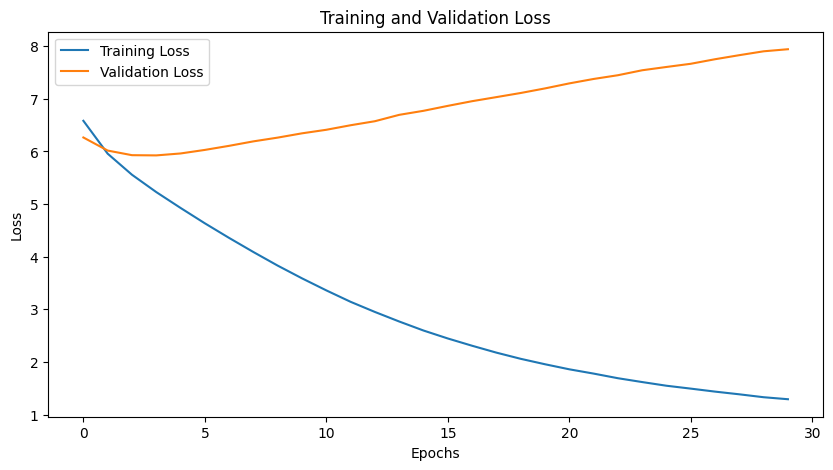

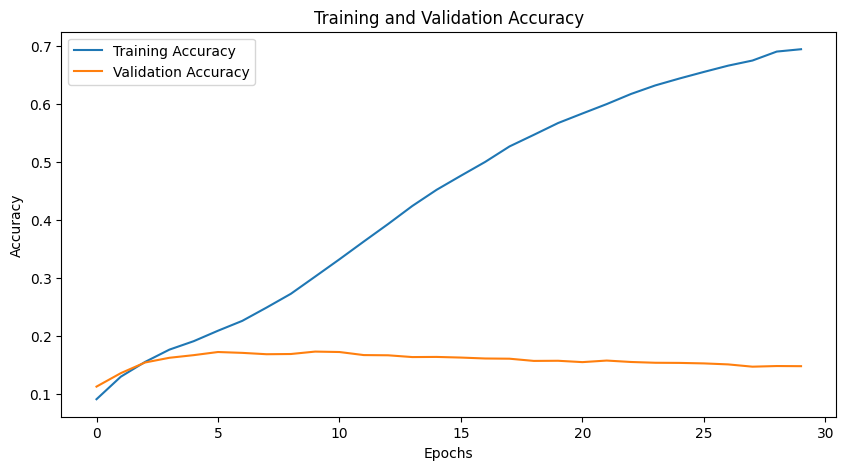

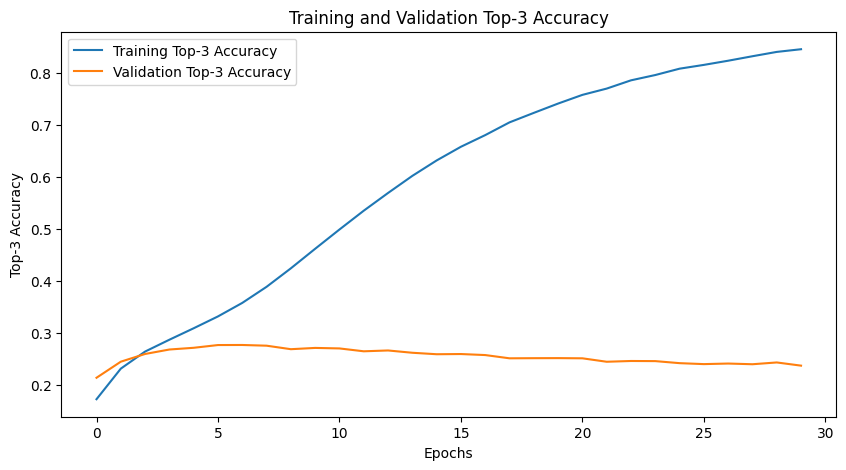

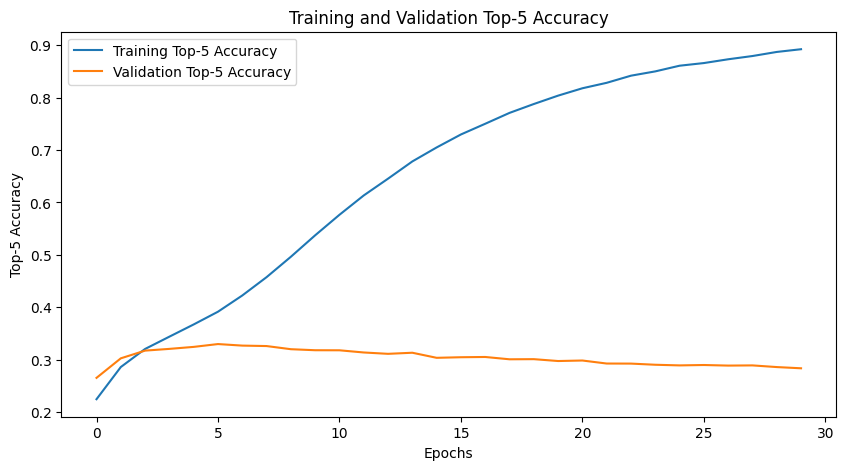

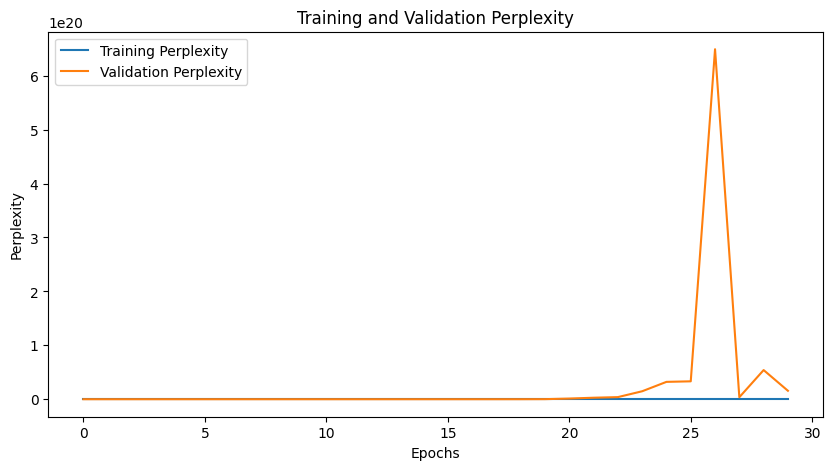

In [9]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Top-3 Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['top_3_accuracy'], label='Training Top-3 Accuracy')
plt.plot(history.history['val_top_3_accuracy'], label='Validation Top-3 Accuracy')
plt.title('Training and Validation Top-3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top-3 Accuracy')
plt.legend()
plt.show()

# Plot Top-5 Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['top_5_accuracy'], label='Training Top-5 Accuracy')
plt.plot(history.history['val_top_5_accuracy'], label='Validation Top-5 Accuracy')
plt.title('Training and Validation Top-5 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top-5 Accuracy')
plt.legend()
plt.show()

# Plot Perplexity
plt.figure(figsize=(10, 5))
plt.plot(history.history['perplexity'], label='Training Perplexity')
plt.plot(history.history['val_perplexity'], label='Validation Perplexity')
plt.title('Training and Validation Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
plt.show()




In [10]:
# Test the function
seed_text = "She is my"
predict_and_display_top_five_words(seed_text, model, tokenizer)

In [12]:
# Save the model architecture to JSON
model_json = model.to_json()
with open("en_Model.json", "w") as json_file:
    json_file.write(model_json)

# Save the weights to HDF5
model.save_weights("en_model_weights.h5")

# Save the tokenizer to a file
with open('en_tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
# Example seed text for demonstration
seed_text = "She is my"

# Example feedback text
feedback_text = "best"

# Update the model with feedback
updated_model = update_model_with_feedback(model, tokenizer, feedback_text, seed_text)


top_five_words = predict_top_five_words(updated_model, tokenizer, seed_text)
print(top_five_words)


['unk', 'even', 'mr', 'right', 'the']


## **How to load models**

In [ ]:
import os
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

base_dir = os.getcwd()
# Load the model architecture and weights
try:
    with open(os.path.join(base_dir, 'en_Model.json'), 'r') as json_file:
        loaded_model_json = json_file.read()
    model = model_from_json(loaded_model_json)
    model.load_weights(os.path.join(base_dir, 'en_model_weights.h5'))
except Exception as e:
    print(f"Error loading the model: {e}")
    exit(1)

# Load the tokenizer
try:
    with open(os.path.join(base_dir, 'en_tokenizer.pkl'), 'rb') as handle:
        tokenizer = pickle.load(handle)
except Exception as e:
    print(f"Error loading the tokenizer: {e}")
    exit(1)

trie = load_trie('en_trie.pkl')

In [14]:
sl = ['she ','ex']

for x in sl:
  if (x[-1] == ' '):
    print(predict_top_five_words(model, tokenizer, x))
  else:
    print(trie.autocomplete(x)[:5])

['was', 'did', 'says', 'won', 'said']
['exchange', 'executive', 'expected', 'expects', 'example']


# **Arabic Model**

In [2]:
# Specify the filename
input_file = 'arabic_data.txt'

# Read the contents of the file
with open(input_file, 'r', encoding='utf-8') as infile:
    ar_data = infile.read()


ar_tokens = ar_preprocess(ar_data)
ar_trie = build_trie_with_frequency(ar_tokens)
save_trie(ar_trie, 'ar_trie.pkl')
ar_data = ar_data[:270000]

# Tokenize words
tokenized_sentences = ar_preprocess_pipeline(ar_data)
ar_tokenizer = Tokenizer(oov_token='<oov>')
ar_tokenizer.fit_on_texts(tokenized_sentences)
total_words = len(ar_tokenizer.word_index) + 1
# tokenizer.word_counts
# tokenizer.word_index


# Generate input sequences
input_sequences = []
for line in tokenized_sentences:
    token_list = ar_tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i + 1]
        input_sequences.append(n_gram_sequence)

# Pad sequences
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))





# Creates labels with input sequences
X,labels = input_sequences[:,:-1],input_sequences[:,-1]
ys = tf.keras.utils.to_categorical(labels, num_classes=total_words)

# Split data into training, validation, and test sets
X_train_temp, X_val_test, y_train_temp, y_val_test = train_test_split(X, ys, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)


# Define your model
ar_model = tf.keras.Sequential()
ar_model.add(tf.keras.layers.Embedding(total_words, 100))
ar_model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)))
ar_model.add(tf.keras.layers.Dropout(0.2))
ar_model.add(tf.keras.layers.Dense(total_words, activation='softmax'))

# Compile the model with multiple metrics
adam = tf.keras.optimizers.Adam(learning_rate=0.01)
ar_model.compile(loss='categorical_crossentropy', optimizer=adam,
              metrics=['accuracy', top_3_accuracy, top_5_accuracy, perplexity])

# Train the model
history = ar_model.fit(X_train_temp, y_train_temp, epochs=30, validation_data=(X_val, y_val), verbose=1)


Epoch 1/30
1156/1156 [==============================] - 143s 117ms/step - loss: 9.0255 - accuracy: 0.0331 - top_3_accuracy: 0.0727 - top_5_accuracy: 0.0922 - perplexity: 60026.8438 - val_loss: 8.9031 - val_accuracy: 0.0387 - val_top_3_accuracy: 0.0852 - val_top_5_accuracy: 0.1068 - val_perplexity: 143758.1094
Epoch 2/30
1156/1156 [==============================] - 64s 55ms/step - loss: 8.1344 - accuracy: 0.0552 - top_3_accuracy: 0.1037 - top_5_accuracy: 0.1290 - perplexity: 285412.1250 - val_loss: 9.3126 - val_accuracy: 0.0526 - val_top_3_accuracy: 0.0967 - val_top_5_accuracy: 0.1226 - val_perplexity: 608949.6250
Epoch 3/30
1156/1156 [==============================] - 56s 48ms/step - loss: 7.0224 - accuracy: 0.0869 - top_3_accuracy: 0.1464 - top_5_accuracy: 0.1772 - perplexity: 68375.2422 - val_loss: 9.7359 - val_accuracy: 0.0547 - val_top_3_accuracy: 0.1032 - val_top_5_accuracy: 0.1256 - val_perplexity: 16075006.0000
Epoch 4/30
1156/1156 [==============================] - 54s 47ms/ste

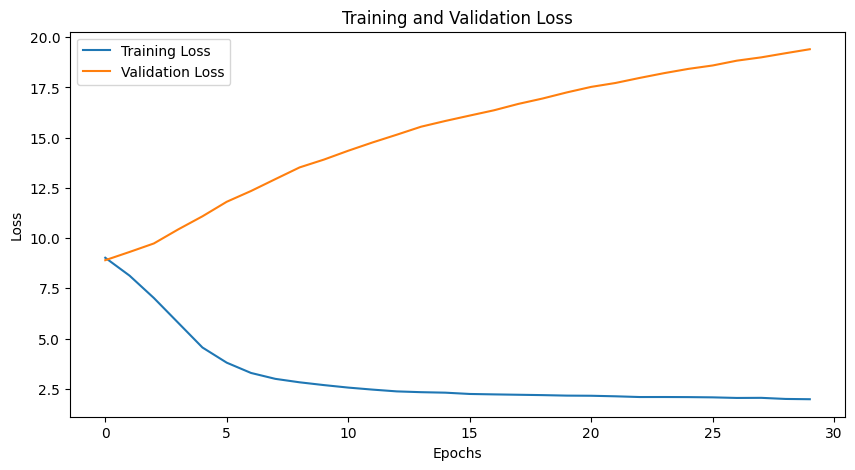

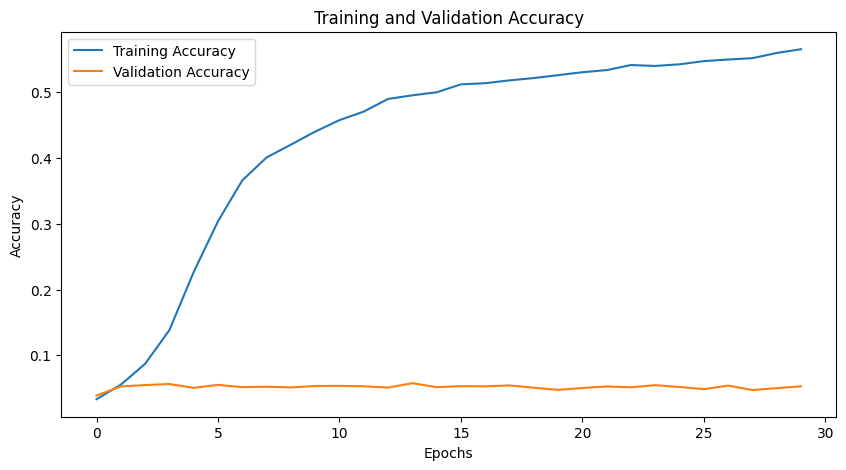

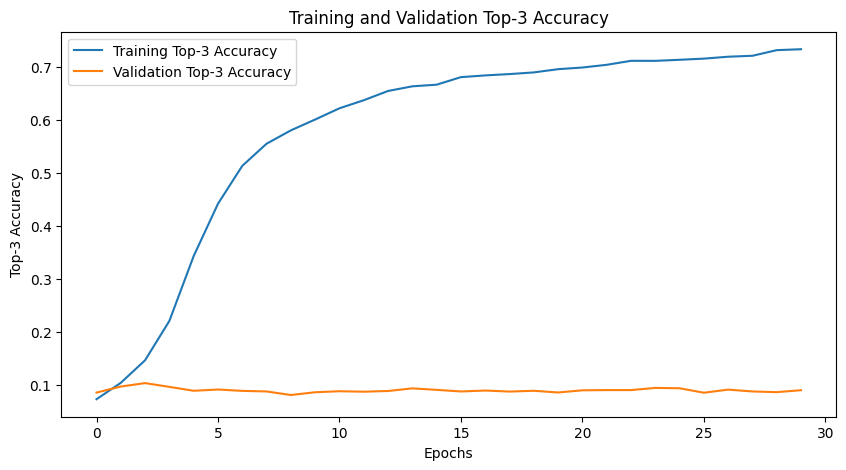

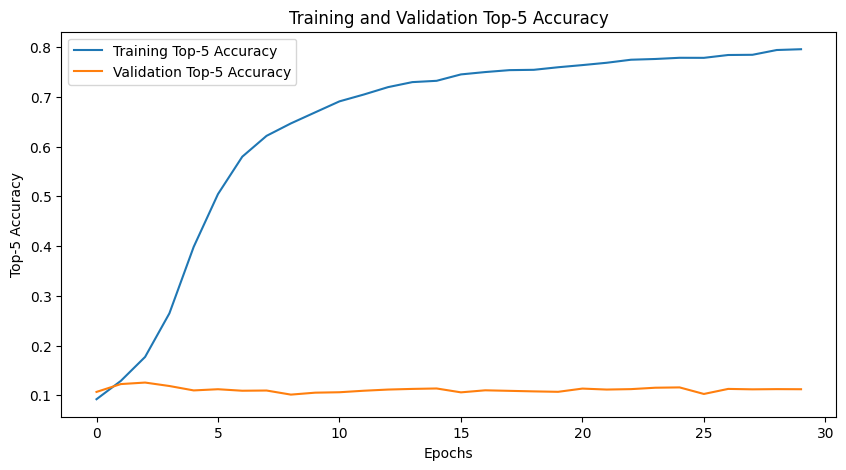

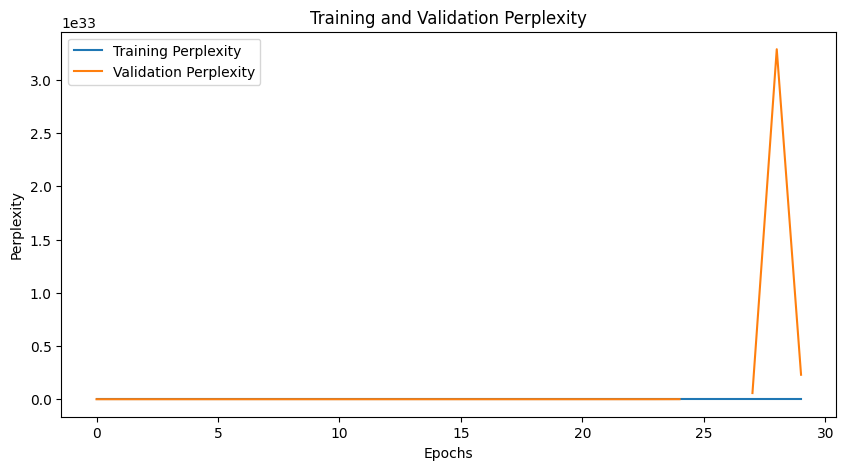

In [3]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Top-3 Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['top_3_accuracy'], label='Training Top-3 Accuracy')
plt.plot(history.history['val_top_3_accuracy'], label='Validation Top-3 Accuracy')
plt.title('Training and Validation Top-3 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top-3 Accuracy')
plt.legend()
plt.show()

# Plot Top-5 Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['top_5_accuracy'], label='Training Top-5 Accuracy')
plt.plot(history.history['val_top_5_accuracy'], label='Validation Top-5 Accuracy')
plt.title('Training and Validation Top-5 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Top-5 Accuracy')
plt.legend()
plt.show()

# Plot Perplexity
plt.figure(figsize=(10, 5))
plt.plot(history.history['perplexity'], label='Training Perplexity')
plt.plot(history.history['val_perplexity'], label='Validation Perplexity')
plt.title('Training and Validation Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
plt.show()




In [4]:
# Save the model architecture to JSON
ar_model_json = ar_model.to_json()
with open("ar_Model.json", "w") as json_file:
    json_file.write(ar_model_json)

# Save the weights to HDF5
ar_model.save_weights("ar_model_weights.h5")

# Save the tokenizer to a file
with open('ar_tokenizer.pkl', 'wb') as handle:
    pickle.dump(ar_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
sl = ['فهي ','خا']

for x in sl:
  if (x[-1] == ' '):
    print(predict_top_five_words(ar_model, ar_tokenizer, x))
  else:
    print(ar_trie.autocomplete(x)[:5])

['باقية', 'في', 'موزعة', 'مجموعة', 'دائرة']
['خاصة', 'خاص', 'خارج', 'خالد', 'خارجية']
